/home/fangqiang.d/miniconda3/envs/gamba/lib/python3.10/site-packages/truckscenes/truckscenes.py:93: UserWarning: The visualization dependencies are not installed on your system! Run 'pip install "truckscenes-devkit[all]"'.
  warnings.warn('''The visualization dependencies are not installed on your system! '''


Dataset samples: 1170
Train size: 1170, iters: 74
[doppler] N=1516320, mean=-1.3138, std=9.8624, range=(-113.2787, 57.1144)


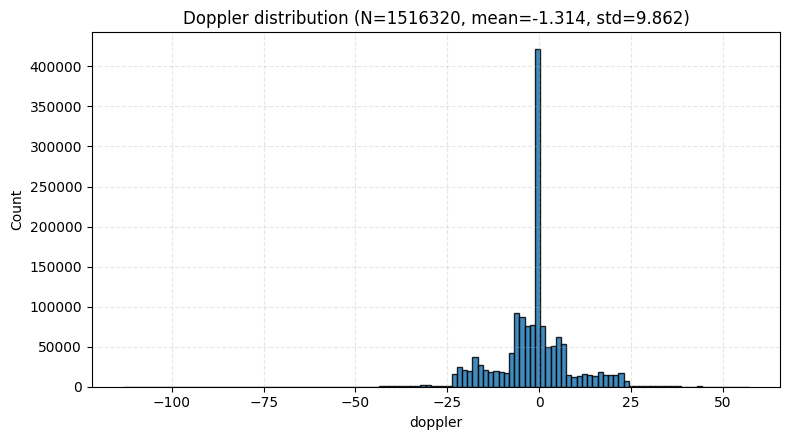

[save] results/analysis/doppler_hist_train.png
[rcs] N=1516320, mean=-7.5565, std=9.9219, range=(-20.0000, 42.0000)


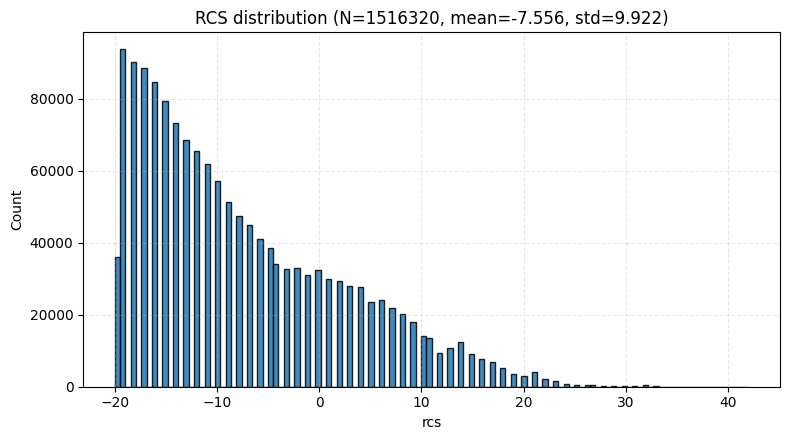

[save] results/analysis/rcs_hist_train.png
[x] N=1516320, mean=-0.5696, std=24.7732, range=(-49.9993, 49.9978)


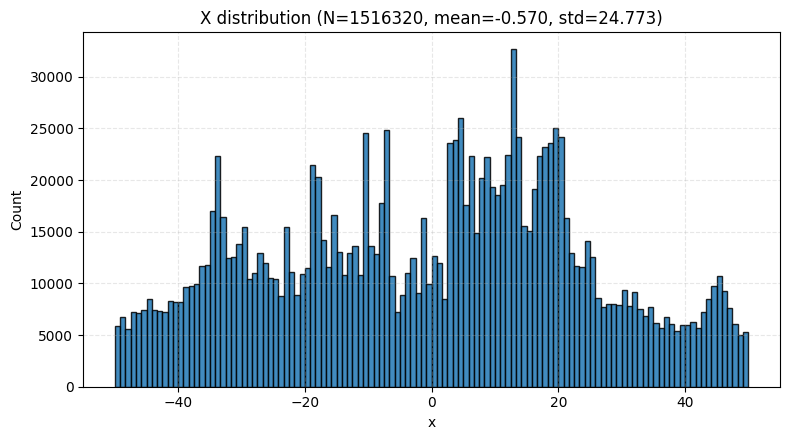

[save] results/analysis/x_hist_train.png
[y] N=1516320, mean=8.8546, std=26.4720, range=(-49.9982, 49.9998)


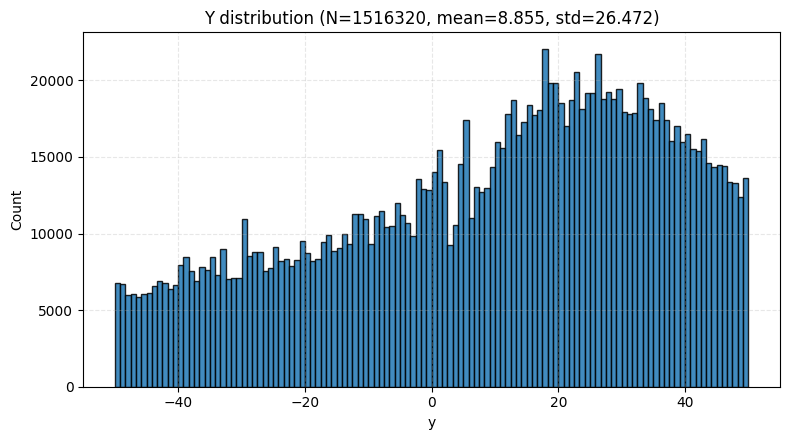

[save] results/analysis/y_hist_train.png
[z] N=1516320, mean=1.0000, std=0.0000, range=(-1.0000, 1.0000)


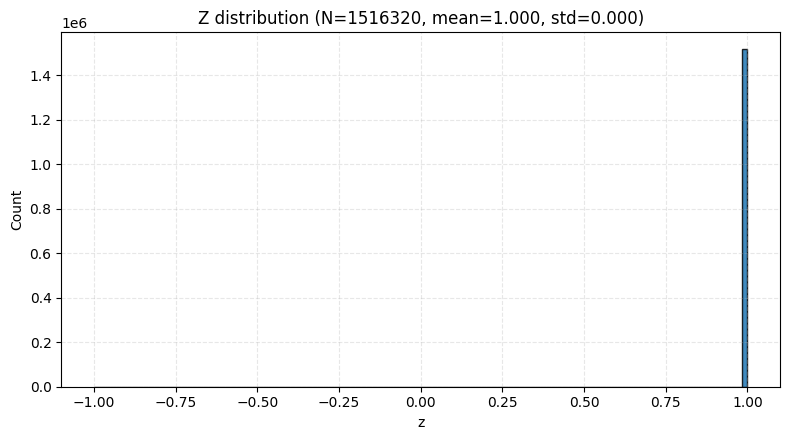

[save] results/analysis/z_hist_train.png
Done.


In [1]:
# ===== 全训练集分布：doppler / rcs / x / y / z =====
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

from core.options import Options
from core.truckscenes_dataset import MANTruckscenesDataset as Dataset

# ---------- 小工具 ----------
def to_1d_numpy(x):
    """任意形状 -> 1D numpy，去掉 NaN/Inf。"""
    if torch.is_tensor(x):
        x = x.detach().cpu().numpy()
    x = np.asarray(x).reshape(-1)
    x = x[np.isfinite(x)]
    return x

def to_xyz_numpy(points):
    """
    points: 可能是 [P,3] / [B,P,3] / [3,P] / [B,3,P]
    统一返回 [N,3] numpy，去掉 NaN/Inf 行。
    """
    if torch.is_tensor(points):
        points = points.detach().cpu().numpy()
    arr = np.asarray(points)
    # 尝试把最后一维压成 3
    if arr.ndim == 2 and arr.shape[0] == 3:      # [3,P]
        arr = arr.transpose(1, 0)                # -> [P,3]
    elif arr.ndim == 3 and arr.shape[-1] == 3:   # [B,P,3]
        arr = arr.reshape(-1, 3)                 # -> [B*P,3]
    elif arr.ndim == 3 and arr.shape[1] == 3:    # [B,3,P]
        arr = arr.transpose(0, 2, 1).reshape(-1, 3)  # -> [B*P,3]
    elif arr.ndim == 2 and arr.shape[-1] == 3:   # [P,3]
        pass
    else:
        raise ValueError(f"Unexpected points shape: {arr.shape}")

    # 过滤 NaN/Inf 行
    mask = np.all(np.isfinite(arr), axis=1)
    return arr[mask]

def pass1_minmax(dataloader, fetch_fn, percentile_clip=False, q_lo=0.5, q_hi=99.5):
    """先估变量的全局范围；可选用分位数裁剪。"""
    vmin, vmax = None, None
    qs = []
    total = 0
    for batch in dataloader:
        arr = fetch_fn(batch)
        if arr.size == 0:
            continue
        mn, mx = float(arr.min()), float(arr.max())
        vmin = mn if vmin is None else min(vmin, mn)
        vmax = mx if vmax is None else max(vmax, mx)
        total += arr.size
        if percentile_clip:
            # 抽样或直接收集分位（全量也行，就是慢点）
            qs.append(np.quantile(arr, [q_lo/100.0, q_hi/100.0]))
    if total == 0:
        return -1.0, 1.0, 0  # fallback
    if percentile_clip and qs:
        qs = np.stack(qs, axis=0)
        vmin = float(np.median(qs[:, 0]))
        vmax = float(np.median(qs[:, 1]))
    # 避免退化
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmax <= vmin:
        vmin, vmax = -1.0, 1.0
    return vmin, vmax, total

def pass2_hist(dataloader, fetch_fn, bin_edges):
    """用固定 bins 进行累计直方图，并顺便算均值/方差。"""
    counts = np.zeros(len(bin_edges) - 1, dtype=np.int64)
    total = 0
    s1 = 0.0
    s2 = 0.0
    vmin, vmax = bin_edges[0], bin_edges[-1]
    for batch in dataloader:
        arr = fetch_fn(batch)
        if arr.size == 0:
            continue
        arr = np.clip(arr, vmin, vmax)
        h, _ = np.histogram(arr, bins=bin_edges)
        counts += h
        total += arr.size
        s1 += arr.sum()
        s2 += (arr ** 2).sum()
    mean = s1 / max(1, total)
    var = max(0.0, s2 / max(1, total) - mean ** 2)
    std = np.sqrt(var)
    return counts, total, mean, std

def plot_hist(counts, bin_edges, title, out_path, xlabel="value"):
    centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.figure(figsize=(8, 4.5))
    plt.bar(centers, counts, width=(bin_edges[1]-bin_edges[0]),
            align='center', edgecolor='k', alpha=0.85)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.title(title)
    plt.grid(True, ls='--', alpha=0.3)
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.tight_layout()
    plt.savefig(out_path, dpi=180)
    plt.show()
    print(f"[save] {out_path}")

# ---------- 构造训练集 ----------
opt = Options()
opt.data_mode   = 's3'
opt.batch_size  = 16
opt.num_workers = 4

train_set = Dataset(opt, training=True)
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=opt.batch_size,
    shuffle=False,
    num_workers=opt.num_workers,
    pin_memory=True,
    drop_last=False,
    persistent_workers=(opt.num_workers > 0),
)

print(f"Train size: {len(train_set)}, iters: {len(train_loader)}")

# ---------- 统计 doppler ----------
use_percentile_clip = False   # 如遇极端值，可改 True
num_bins = 120

# Pass-1: 范围
dop_vmin, dop_vmax, dop_N = pass1_minmax(
    train_loader,
    fetch_fn=lambda b: to_1d_numpy(b["radar_gt"]["doppler"]),
    percentile_clip=use_percentile_clip,
)

# Pass-2: 直方图
dop_bins = np.linspace(dop_vmin, dop_vmax, num_bins + 1)
dop_counts, dop_total, dop_mean, dop_std = pass2_hist(
    train_loader,
    fetch_fn=lambda b: to_1d_numpy(b["radar_gt"]["doppler"]),
    bin_edges=dop_bins,
)

print(f"[doppler] N={dop_total}, mean={dop_mean:.4f}, std={dop_std:.4f}, range=({dop_vmin:.4f}, {dop_vmax:.4f})")
plot_hist(
    dop_counts, dop_bins,
    title=f"Doppler distribution (N={dop_total}, mean={dop_mean:.3f}, std={dop_std:.3f})",
    out_path="results/analysis/doppler_hist_train.png",
    xlabel="doppler",
)

# ---------- 统计 rcs ----------
rcs_vmin, rcs_vmax, rcs_N = pass1_minmax(
    train_loader,
    fetch_fn=lambda b: to_1d_numpy(b["radar_gt"]["rcs"]),
    percentile_clip=use_percentile_clip,
)
rcs_bins = np.linspace(rcs_vmin, rcs_vmax, num_bins + 1)
rcs_counts, rcs_total, rcs_mean, rcs_std = pass2_hist(
    train_loader,
    fetch_fn=lambda b: to_1d_numpy(b["radar_gt"]["rcs"]),
    bin_edges=rcs_bins,
)
print(f"[rcs] N={rcs_total}, mean={rcs_mean:.4f}, std={rcs_std:.4f}, range=({rcs_vmin:.4f}, {rcs_vmax:.4f})")
plot_hist(
    rcs_counts, rcs_bins,
    title=f"RCS distribution (N={rcs_total}, mean={rcs_mean:.3f}, std={rcs_std:.3f})",
    out_path="results/analysis/rcs_hist_train.png",
    xlabel="rcs",
)

# ---------- 统计 xyz（分别对 x/y/z 做 1D 直方图） ----------
# Pass-1：范围（为每个维度单独估）
def pass1_xyz_minmax(loader, key="points"):
    mins = [None, None, None]
    maxs = [None, None, None]
    total = 0
    for batch in loader:
        xyz = to_xyz_numpy(batch["radar_gt"][key])  # [N,3]
        if xyz.size == 0:
            continue
        mn = xyz.min(axis=0)  # [3]
        mx = xyz.max(axis=0)  # [3]
        for d in range(3):
            mins[d] = float(mn[d]) if mins[d] is None else min(mins[d], float(mn[d]))
            maxs[d] = float(mx[d]) if maxs[d] is None else max(maxs[d], float(mx[d]))
        total += xyz.shape[0]
    # 兜底
    for d in range(3):
        if mins[d] is None or maxs[d] is None or not np.isfinite(mins[d]) or not np.isfinite(maxs[d]) or maxs[d] <= mins[d]:
            mins[d], maxs[d] = -1.0, 1.0
    return mins, maxs, total

xyz_mins, xyz_maxs, xyz_total = pass1_xyz_minmax(train_loader, key="points")

# Pass-2：每个维度累计直方图
def pass2_xyz_hist(loader, bin_edges_list):
    counts_list = [np.zeros(len(be)-1, dtype=np.int64) for be in bin_edges_list]
    totals = [0, 0, 0]
    sums = [0.0, 0.0, 0.0]
    sums2 = [0.0, 0.0, 0.0]
    for batch in loader:
        xyz = to_xyz_numpy(batch["radar_gt"]["points"])  # [N,3]
        if xyz.size == 0:
            continue
        for d in range(3):
            vmin, vmax = bin_edges_list[d][0], bin_edges_list[d][-1]
            arr = np.clip(xyz[:, d], vmin, vmax)
            h, _ = np.histogram(arr, bins=bin_edges_list[d])
            counts_list[d] += h
            totals[d] += arr.size
            sums[d] += arr.sum()
            sums2[d] += (arr**2).sum()
    means = [sums[d] / max(1, totals[d]) for d in range(3)]
    stds = [np.sqrt(max(0.0, sums2[d] / max(1, totals[d]) - means[d]**2)) for d in range(3)]
    return counts_list, totals, means, stds

xyz_bins = [np.linspace(xyz_mins[d], xyz_maxs[d], num_bins + 1) for d in range(3)]
xyz_counts, xyz_totals, xyz_means, xyz_stds = pass2_xyz_hist(train_loader, xyz_bins)

labels = ["x", "y", "z"]
for d in range(3):
    print(f"[{labels[d]}] N={xyz_totals[d]}, mean={xyz_means[d]:.4f}, std={xyz_stds[d]:.4f}, "
          f"range=({xyz_mins[d]:.4f}, {xyz_maxs[d]:.4f})")
    plot_hist(
        xyz_counts[d], xyz_bins[d],
        title=f"{labels[d].upper()} distribution (N={xyz_totals[d]}, mean={xyz_means[d]:.3f}, std={xyz_stds[d]:.3f})",
        out_path=f"results/analysis/{labels[d]}_hist_train.png",
        xlabel=labels[d],
    )

print("Done.")
